# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,...,N$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$.

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Utilities

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

## Generate Toy Dataset

In [5]:
N = 1000
D = 3
T = 2

In [6]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, alpha):
    z = np.random.randn(N) * softplus(alpha)**(1/2.)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

In [7]:
# paramters
alpha = np.float64(4.)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'alpha': alpha,
    'beta0': beta0,
    'beta': beta
}

In [8]:
x,y,z = generate_data(N, D, T, beta0, beta, alpha)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [9]:
def sigmoid_normal_prob(x, beta0, beta, alpha):
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.math.softplus(alpha)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [10]:
def sigmoid_normal_likelihood(x, y, beta0, beta, alpha):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, alpha)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [11]:
def laplace_approx(x, y, beta0, beta, alpha):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/softplus(alpha) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/softplus(alpha) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [12]:
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)

In [13]:
z.var(), (z-mu).var()

(4.143633743589595, 2.0612395684360387)

## IWELBO approximation of Evidence

In [14]:
def pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [15]:
def IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return iwelbo

In [16]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, alpha).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64).numpy()

In [17]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.2847267502723065, -1.2512783976367923, -1.2291615676265808)

## Maximum Likelihood by Different Approximation

In [18]:
objectives = {
    "signorm": lambda beta0, beta, alpha, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, alpha),
    "elbo": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0., dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    alpha_   = tf.Variable(1., dtype=tf.float64)
    
    # Gradient Descent
    for t in range(2001):
        
        rho_t = 0.5/(1+t)**0.7
        x,y,_ = generate_data(N, D, T, beta0, beta, alpha)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, alpha_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), alpha_.numpy())
            score = obj_func(beta0_, beta_, alpha_, mu, sigma)
        dbeta0_, dbeta_, dalpha_ = g.gradient(score, [beta0_, beta_, alpha_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        alpha_ = alpha_ + dalpha_
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'alpha': alpha_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198892
#iter: 200,	loss: 1.3338499316608192
#iter: 400,	loss: 1.2233954337681603
#iter: 600,	loss: 1.3211332752467222
#iter: 800,	loss: 1.3194620191368733
#iter: 1000,	loss: 1.3010750886336444
#iter: 1200,	loss: 1.277781155383243
#iter: 1400,	loss: 1.3180988694657436
#iter: 1600,	loss: 1.3298549877572186
#iter: 1800,	loss: 1.2757703866722734
#iter: 2000,	loss: 1.2794990581094574

training elbo...
#iter: 0,	loss: 1.3416447708365735
#iter: 200,	loss: 1.23367775208622
#iter: 400,	loss: 1.3118062453864912
#iter: 600,	loss: 1.2243050627561685
#iter: 800,	loss: 1.236567895027745
#iter: 1000,	loss: 1.2160665651814317
#iter: 1200,	loss: 1.216889043716758
#iter: 1400,	loss: 1.2531154427446582
#iter: 1600,	loss: 1.2305513866203504
#iter: 1800,	loss: 1.256499890484457
#iter: 2000,	loss: 1.2540414866439926

training iwelbo8...
#iter: 0,	loss: 1.3280620267221166
#iter: 200,	loss: 1.2472004017257066
#iter: 400,	loss: 1.2915956360053458
#iter: 600,	loss

In [19]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [20]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,alpha,beta0,beta1,beta2,beta3
ground_truth,4.000000,0.000000,-0.510683,0.624459,-0.606740
signorm,0.037412,-0.003436,-0.356226,0.430398,-0.424138
elbo,0.759746,0.005266,-0.385563,0.467172,-0.450814
iwelbo8,2.289314,0.006456,-0.427965,0.531240,-0.511883
iwelbo64,3.285273,-0.002133,-0.442995,0.543898,-0.530270
iwelbo512,3.494036,-0.002588,-0.454266,0.555779,-0.540395


##### Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation, even for simple this model. 

## MLMC

In [21]:
def pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, alpha, mu, sigma)
    return scores

In [22]:
def dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return diwelbo

In [23]:
def IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    
    N, T, D = x.shape

    levels = np.arange(max_level)
    weights = 2.**(-(b+1)/2*levels)
    weights /= sum(weights)
    weights = np.concatenate([[w0], (1-w0)*weights])
    
    if randomize==True:
         Ns = np.random.multinomial(n=N, pvals=weights)
        
    elif randomize==False:
        Ns = np.zeros_like(levels)
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
                       
        if randomize==True:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l)
        
        N_offset += Ns[i]
    return score

In [24]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    

In [25]:
IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=True)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2419192634593363>

In [26]:
IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2396203109690793>

## MLMC codition check for objective

In [27]:
def conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [28]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=10
conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

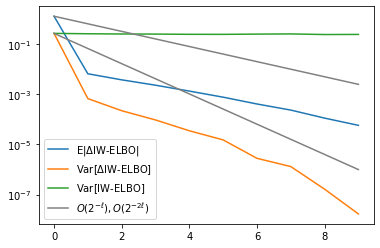

In [29]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[0]
plt.plot(s*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$',
            r'$O(2^{-\ell}), O(2^{-2\ell})$'])
plt.yscale('log')

In [30]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.247732,1.249388,1.816552e+00,2.597161e-01,0.259716
1,0.006423,0.006423,7.015809e-04,6.603281e-04,0.250904
2,0.003685,0.003685,2.313465e-04,2.177688e-04,0.245774
3,0.002253,0.002253,9.858101e-05,9.350556e-05,0.243564
4,0.001314,0.001314,3.642310e-05,3.469664e-05,0.238542
5,0.000752,0.000752,1.558370e-05,1.501760e-05,0.237795
6,0.000403,0.000403,2.941728e-06,2.779193e-06,0.242994
7,0.000231,0.000231,1.358146e-06,1.304927e-06,0.247169
8,0.000111,0.000111,1.766984e-07,1.644637e-07,0.233854
9,0.000057,0.000057,2.029065e-08,1.703959e-08,0.236216


## MLMC codition check for gradients

In [31]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [alpha]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)        
    
    def get_grad(args):
        
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            alpha_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        
        del g
        
        return a,b
    
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])
    grad_iwelbos = tf.squeeze(grads[1])
    
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [32]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=10
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

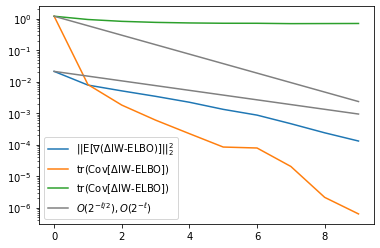

In [33]:
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[0]
plt.plot(s*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell})$'])
plt.yscale('log')

When we take gradient w.r.t. $\theta_1: \ \tau=\exp\theta_1$, $b\approx1$ for $V_\ell\propto 2^{-b\ell}$. 
<br>
However, taking gradient w.r.t. $\theta_2: \ \tau^2=:\mathrm{softplus}(\theta_2)$, we obtain $b\gtrapprox1$ for $V_\ell\propto 2^{-b\ell}$

In [34]:
conv_stats

,norm_mean_grad_dIWELBO,mean_norm_grad_dIWELBO,mean_squared_norm_grad_dIWELBO,trace_covariance_grad_dIWELBO,trace_covariance_grad_IWELBO
0,0.021287,0.906735,1.201837e+00,1.201384e+00,1.201384
1,0.007821,0.034185,8.175977e-03,8.114804e-03,0.946134
2,0.005121,0.017873,1.836496e-03,1.810275e-03,0.827359
3,0.003436,0.010165,6.143921e-04,6.025861e-04,0.767039
4,0.002229,0.005797,2.289225e-04,2.239560e-04,0.735874
5,0.001326,0.003238,8.598297e-05,8.422567e-05,0.719336
6,0.000870,0.001876,7.927947e-05,7.852307e-05,0.717869
7,0.000464,0.000970,2.057220e-05,2.035689e-05,0.699719
8,0.000239,0.000505,2.181499e-06,2.124587e-06,0.703890
9,0.000131,0.000269,6.501393e-07,6.330477e-07,0.707692


## Cost comparison of objective

In [35]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    NMC_ests.append( IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**9).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=False).numpy() )
    RandMLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=True).numpy() )

In [36]:
print("std-div of NMC estimator:      ", np.std(NMC_ests))
print("std-div of MLMC estimator:     ", np.std(MLMC_ests))
print("std-div of RandMLMC estimator: ", np.std(RandMLMC_ests))

std-div of NMC estimator:       0.008230205099250482
std-div of MLMC estimator:      0.009498309694484059
std-div of RandMLMC estimator:  0.011435872766900113


In [37]:
%%timeit
IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**9)

184 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=False)

55.5 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=9, w0=0.90, b=1.8, randomize=True)

48 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cost comparison of gradients

In [40]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(100):
    N0 = 2000
    x,y,_ = generate_data(N=N0, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    
    param = tf.concat([beta, [beta0], [alpha]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(param)
        beta_ = param[:D]
        beta0_ = param[D]
        alpha_ = param[D+1]
        nmc_est = IWELBO(x, y, beta0_, beta_, alpha_, mu, sigma, n_MC=2**12)
        mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, alpha_, mu, sigma, max_level=12, w0=0.8, b=1,  randomize=False)
        randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, alpha_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)
            
    nmc_est = g.gradient(nmc_est, param)
    mlmc_est = g.gradient(mlmc_est, param)
    randmlmc_est = g.gradient(randmlmc_est, param)
    
    del g
        
    NMC_ests.append( nmc_est )
    MLMC_ests.append( mlmc_est )
    RandMLMC_ests.append( randmlmc_est )

In [41]:
print("E||grad||^2 of NMC estimator:      ", np.mean(np.linalg.norm(NMC_ests)))
print("E||grad||^2 of MLMC estimator:     ", np.mean(np.linalg.norm(MLMC_ests)))
print("E||grad||^2 of RandMLMC estimator: ", np.mean(np.linalg.norm(RandMLMC_ests)))

E||grad||^2 of NMC estimator:       0.18583349912920039
E||grad||^2 of MLMC estimator:      0.2938377708735826
E||grad||^2 of RandMLMC estimator:  0.2873820105197591


In [42]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    alpha_ = param[D+1]
    nmc_est = IWELBO(x, y, beta0_, beta_, alpha_, mu, sigma, n_MC=2**12)

nmc_est = g.gradient(nmc_est, param)

1.14 s ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    alpha_ = param[D+1]
    mlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, alpha_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=False)

mlmc_est = g.gradient(mlmc_est, param)

168 ms ± 790 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
with tf.GradientTape(persistent=True) as g:
    g.watch(param)
    beta_ = param[:D]
    beta0_ = param[D]
    alpha_ = param[D+1]
    randmlmc_est = IWELBO_MLMC(x, y, beta0_, beta_, alpha_, mu, sigma, max_level=12, w0=0.8, b=1, randomize=True)

randmlmc_est = g.gradient(randmlmc_est, param)

141 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
